Dataset from http://www.robots.ox.ac.uk/~vgg/data/flowers/17/

In [1]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt



Using TensorFlow backend.


### Loading the VGG16 Model

In [2]:
# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg16.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


### Let's make a function that returns our FC Head

In [3]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

### Let's add our FC Head back onto VGG

In [4]:
num_classes = 17

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs=vgg16.input, outputs=FC_Head)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Loading Flowers Dataset

In [5]:
train_data_dir = '17_flowers/train'
validation_data_dir = '17_flowers/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_batchsize = 16
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical')

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


### Training our top layers

In [7]:
checkpoint = ModelCheckpoint("flowers_vgg1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

In [8]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

In [9]:
nb_train_samples = 1190
nb_validation_samples = 170

epochs = 25
batch_size = 16

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/25
74/74 [==============================] - 70s 942ms/step - loss: 2.5196 - acc: 0.2905 - val_loss: 1.4203 - val_acc: 0.6100

Epoch 00001: val_loss improved from inf to 1.42029, saving model to flowers_vgg1.h5
Epoch 2/25
74/74 [==============================] - 58s 785ms/step - loss: 1.5397 - acc: 0.5113 - val_loss: 0.6263 - val_acc: 0.8500

Epoch 00002: val_loss improved from 1.42029 to 0.62628, saving model to flowers_vgg1.h5
Epoch 3/25
74/74 [==============================] - 57s 766ms/step - loss: 1.2510 - acc: 0.6205 - val_loss: 0.6725 - val_acc: 0.8300

Epoch 00003: val_loss did not improve from 0.62628
Epoch 4/25
74/74 [==============================] - 80s 1s/step - loss: 1.1105 - acc: 0.6439 - val_loss: 0.5877 - val_acc: 0.8500

Epoch 00004: val_loss improved from 0.62628 to 0.58773, saving model to flowers_vgg1.h5
Epoch 5/25
74/74 [==============================] - 96s 1s/step - loss: 0.9555 - acc: 0.6988 - val_loss: 0.6191 - val_acc: 0.8600

Epoch 00005: val_loss did

In [11]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

11/11 [==============================] - 9s 779ms/step

Test result: 85.455 loss: 0.504


In [12]:
model.save("flowers_vgg16.h5")

## Confusion Matrix

In [13]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 170 images belonging to 17 classes.


In [14]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [15]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)

In [16]:
y_pred_label = np.argmax(y_pred, axis=1)

In [17]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Confusion Matrix
[[ 8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 1  3  0  1  0  1  0  0  0  1  0  0  0  0  1  2  0]
 [ 0  3  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  1  0  0  0  0  5  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]]
Classification Report
              precision    recall  f1-scor

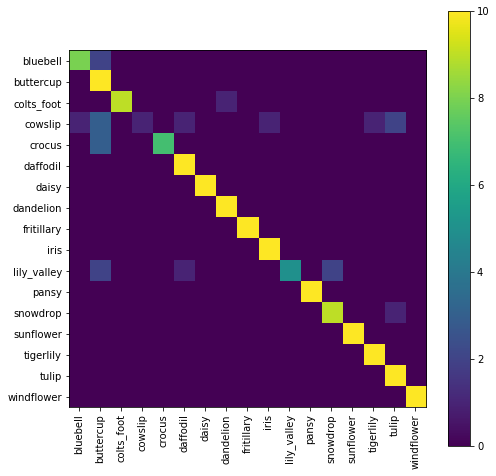

In [18]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
plt.show();

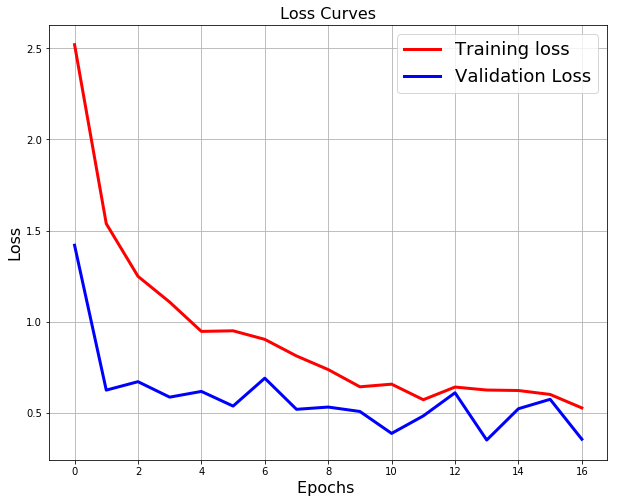

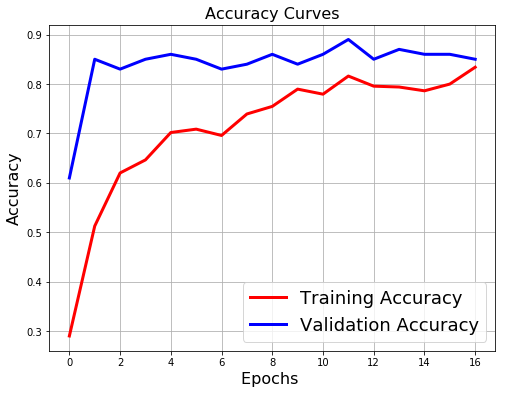

In [19]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

### Loading our classifer


In [20]:
classifier = load_model("flowers_vgg16.h5")

### Testing on some images

In [21]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

In [14]:
flowers_breeds_dict = {"[0]": "bluebell", 
                      "[1]": "buttercup",
                      "[2]": "colts_foot",
                      "[3]": "cowslip",
                      "[4]": "crocus",
                      "[5]": "daffodil",
                      "[6]": "daisy",
                      "[7]": "dandelion",
                      "[8]": "fritillary",
                      "[9]": "iris",
                      "[10]": "lily_valley",
                      "[11]": "pansy",
                      "[12]": "snowdrop",
                      "[13]": "sunflower",
                      "[14]": "tigerlily",
                      "[15]": "tulip",
                      "[16]": "windflower"}

flowers_breeds_dict_n = {"bluebell": "bluebell ", 
                      "buttercup": "buttercup",
                      "colts_foot": "colts_foot",
                      "cowslip": "cowslip",
                      "crocus": "crocus",
                      "daffodil": "daffodil",
                      "daisy": "daisy",
                      "dandelion": "dandelion",
                      "fritillary": "fritillary",
                      "iris": "iris",
                       "lily_valley":"lily_valley",
                       "pansy":"pansy",
                       "snowdrop":"snowdrop",
                       "sunflower":"sunflower",
                       "tigerlily":"tigerlily",
                       "tulip":"tulip",
                       "windflower":"windflower"}

In [15]:
def draw_test(name, pred, im):
    flowers = flowers_breeds_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, flowers, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + flowers_breeds_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("17_flowers/validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - colts_foot
Class - buttercup
Class - cowslip
Class - lily_valley
Class - windflower
Class - daisy
Class - sunflower
Class - lily_valley
Class - snowdrop
Class - pansy


<img src="VGG16 Flower Classifier.png">

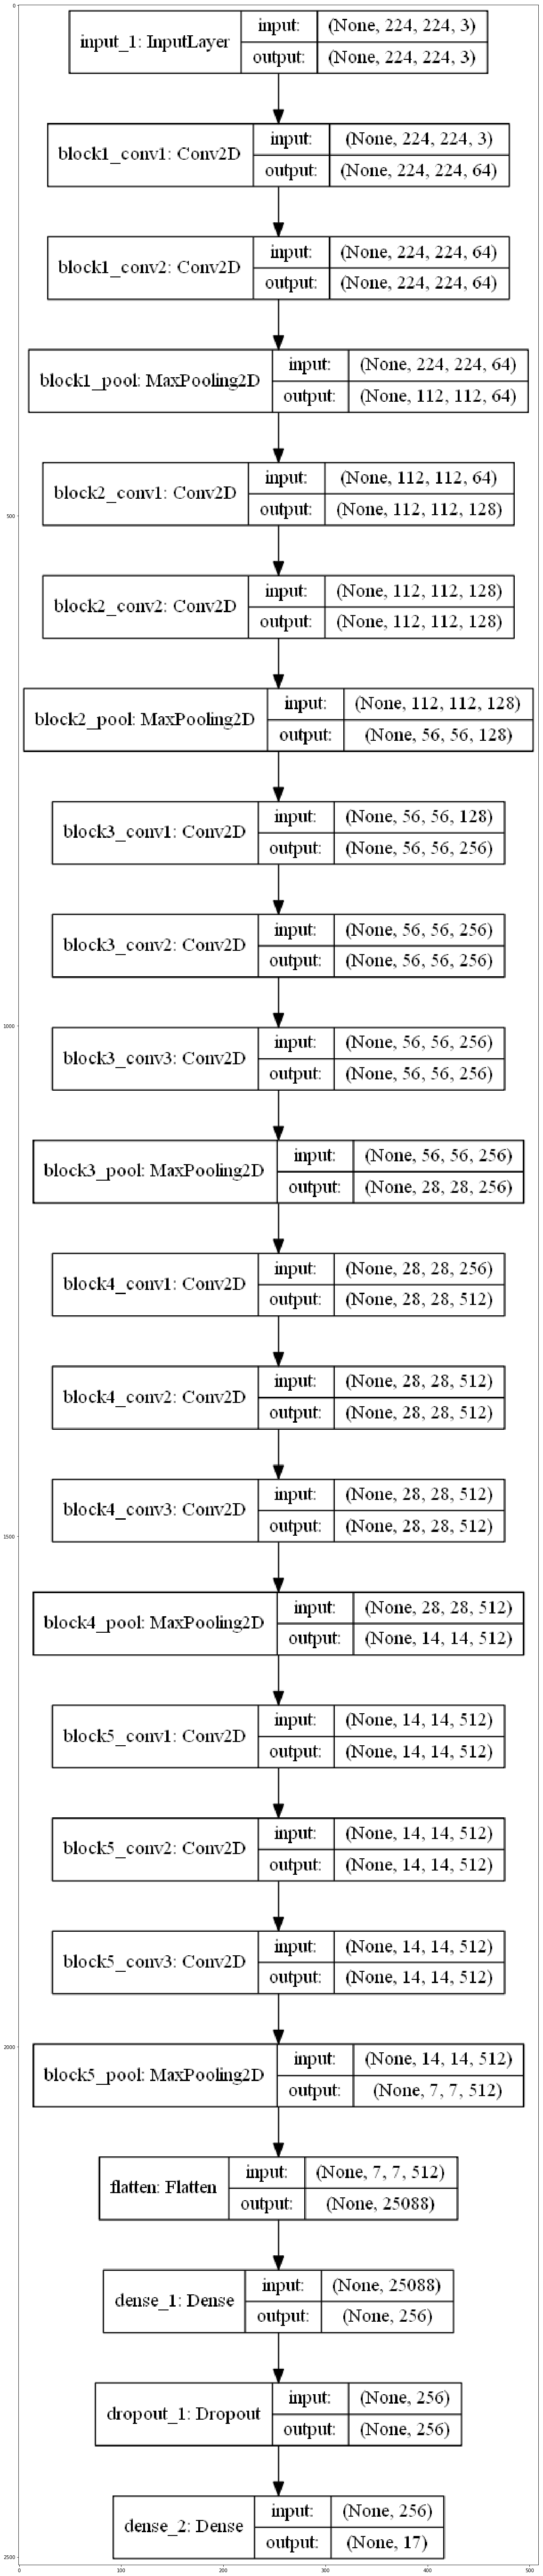

In [17]:
from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Generate the plot
plot_model(model, to_file ='model_plot_flowers17_vgg16.png',
           show_shapes = True,
           show_layer_names = True)

# Show the plot here
img = mpimg.imread('model_plot_flowers17_vgg16.png')
plt.figure(figsize=(60,100))
imgplot = plt.imshow(img)